In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from bgspy.utils import load_pickle, mean_ratio, read_bedcov
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens
from bgspy.nonparametric import Lowess, lowess_bootstrap

## Revisions

Since revisions are relatively minor, I am putting them in a separate notebook. 

Files generated with: 

    bedtools makewindows -g hg38_seqlens.tsv -w 1000000 | gzip > windows_1Mb.bed.gz
    bedtools coverage -b cadd_top6_percent.bed.gz -a windows_1Mb.bed.gz | gzip > cadd6_1Mbp.bed.gz

In [3]:
sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
rm = RecMap('../data/fit_annotation/decode_2019_map.txt', sl)

In [4]:
c6 = load_pickle('../new_fits/cadd6__decode/fits/pop_yri/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [5]:
mp = c6['mbp'].bins.midpoints()
resid = c6['mbp'].resid()
B = c6['mbp'].predict(B=True)
pi = c6['mbp'].pi()

In [6]:
allbins = c6['mbp'].bins

In [7]:
local_recrate = dict()
Mb_recrate = dict()
for chrom in sl:
    if chrom == 'chrX': 
        continue
    local_recrate[chrom] = rm.lookup(chrom, np.array(mp[chrom]))
    
    bins = np.array(c6['mbp'].bins.bins()[chrom])
    start = rm.lookup(chrom, bins[:, 0], cumulative=True)
    end = rm.lookup(chrom, bins[:, 1], cumulative=True)
    width = bins[:, 1] - bins[:, 0]
    Mb_recrate[chrom] = (end-start) /  width

In [8]:
local_recrate.keys()

dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])

In [9]:
local_recrates = list(itertools.chain(*local_recrate.values()))

In [10]:
Mb_recrates = list(itertools.chain(*Mb_recrate.values()))

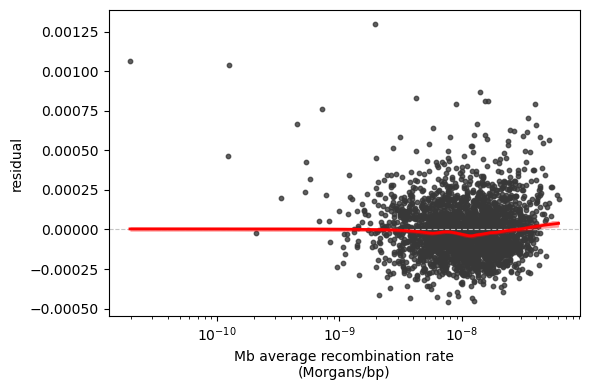

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(Mb_recrates, resid, c='0.22', s=10, alpha=0.8)
ax.semilogx()
ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(Mb_recrates, resid)

lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2)
ax.set_ylabel('residual')
ax.set_xlabel('Mb average recombination rate\n(Morgans/bp)')
fig.savefig('../manuscript/figures/supplementary/suppfigure_recrate_residual.pdf', 
            bbox_inches='tight')
plt.tight_layout()

In [12]:
cov = read_bedcov('../data/fit_annotation/cadd6_1Mbp.bed.gz')
#cov.set_index(['chrom', 'start', 'end'])

In [13]:
cov.head()

,chrom,start,end,nfeature,nbases,length_a,frac
0,chr1,0,1000000,10023,34068,1000000,0.034068
1,chr1,1000000,2000000,17955,69224,1000000,0.069224
2,chr1,2000000,3000000,9186,41676,1000000,0.041676
3,chr1,3000000,4000000,12191,56600,1000000,0.056600
4,chr1,4000000,5000000,7089,31176,1000000,0.031176


In [14]:
d = pd.DataFrame(allbins.flat_bins(), columns=('chrom', 'start', 'end'))
d['resid'] = resid
d['B'] = B
d['recrate'] = Mb_recrates 
d['pi'] = pi
d.set_index(['chrom', 'start', 'end'])
d.head()

,chrom,start,end,resid,B,recrate,pi
0,chr1,1000000,2000000,0.000195,0.500920,3.894731e-09,0.000909
1,chr1,2000000,3000000,-0.000016,0.860676,1.489090e-08,0.001210
2,chr1,3000000,4000000,0.000139,0.901748,4.890751e-08,0.001423
3,chr1,4000000,5000000,0.000205,0.903248,2.477152e-08,0.001491
4,chr1,5000000,6000000,0.000149,0.886551,2.402526e-08,0.001412


In [15]:
d['start'] = d['start'].astype('int64')
d['end'] = d['end'].astype('int64')
merged_df = pd.merge(d, cov, on=['chrom', 'start', 'end'], how='inner')
merged_df['perc'] = merged_df['frac'] * 100

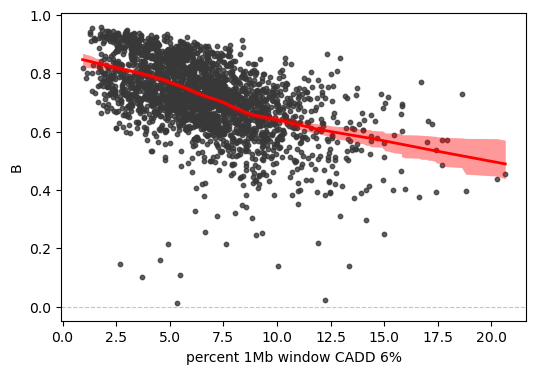

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(merged_df['perc'], merged_df['B'], c='0.22', s=10, alpha=0.8, )
#ax.semilogx()
ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['B'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2)


ax.set_ylabel('B')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_B.pdf', bbox_inches='tight')

In [17]:
merged_df['recrate_quantile'] = pd.qcut(merged_df['recrate'], q=5, labels=False)

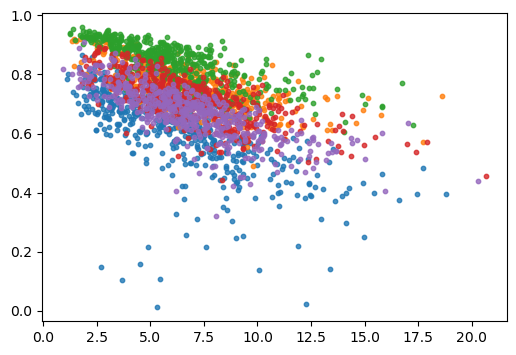

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
for grouper in merged_df['recrate_quantile'].unique():
    mdf = merged_df.loc[merged_df['recrate_quantile'] == grouper]
    ax.scatter(mdf['perc'], mdf['B'], s=10, alpha=0.8, )

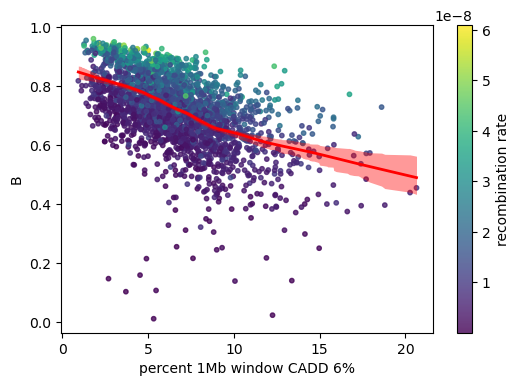

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc'], merged_df['B'], s=10, alpha=0.8, c=merged_df['recrate'])

lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['B'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')
ax.set_ylabel('B')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_B.pdf', bbox_inches='tight')

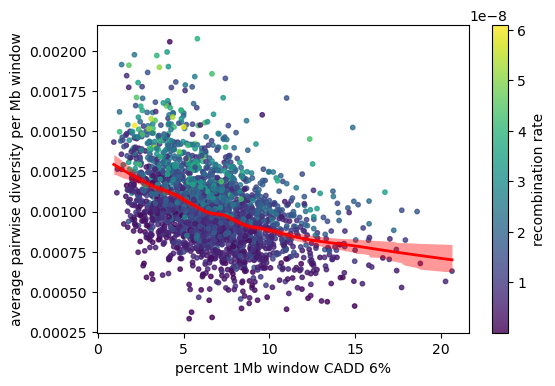

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['recrate'])
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')
ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_pi.pdf', bbox_inches='tight')

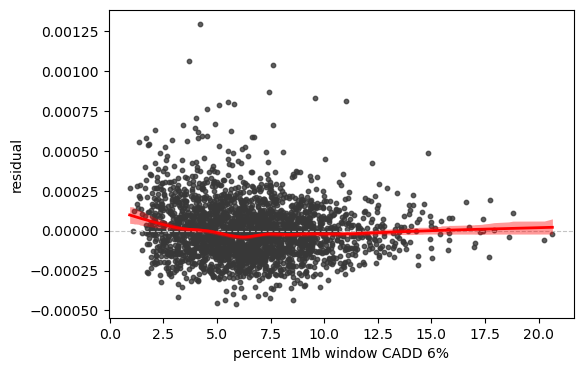

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(merged_df['perc'], merged_df['resid'], c='0.22', s=10, alpha=0.8, )
#ax.semilogx()
ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['resid'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2)


ax.set_ylabel('residual')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_residual.pdf', bbox_inches='tight')

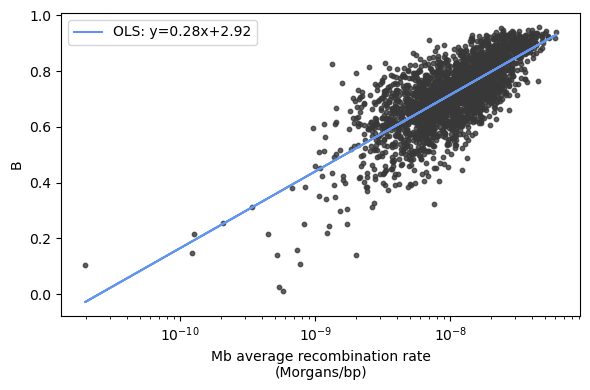

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(Mb_recrates, B, c='0.22', s=10, alpha=0.8)
ax.semilogx()
#ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(Mb_recrates, B)

#lb, ub = lw.bootstrap()
#ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(Mb_recrates), B)

# Create line values
line = slope * np.log10(Mb_recrates) + intercept

# Add the regression line to the plot
ax.plot(Mb_recrates, line, color='cornflowerblue', label=f'OLS: y={slope:.2f}x+{intercept:.2f}')
xp = np.logspace(np.log10(Mb_recrates).min(), np.log10(Mb_recrates).max()) 
#ax.plot(xp, xp/1e-8, c='0.77', linestyle='dashed', linewidth=0.8)

#plt.plot(*lw.pairs(),  c='red', linewidth=2)
ax.set_ylabel('B')
ax.legend()
ax.set_xlabel('Mb average recombination rate\n(Morgans/bp)')
fig.savefig('../manuscript/figures/supplementary/suppfigure_recrate_B.pdf', 
            bbox_inches='tight')

plt.tight_layout()

In [69]:
intercept / 1e6  /2

2.033770358302355e-09

exp(-U) - exp(R) = a + b log(R)

[]

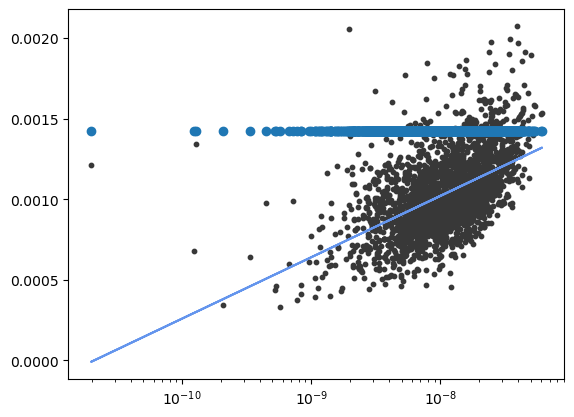

In [122]:
plt.scatter(merged_df['recrate'], merged_df['pi'], c='0.22', s=10)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(merged_df['recrate']), 
                                                              merged_df['pi'])

# Create line values
line = slope * np.log10(merged_df['recrate']) + intercept

# Add the regression line to the plot
plt.plot(merged_df['recrate'], line, color='cornflowerblue', 
        label=f'OLS: y={slope:.2f}x+{intercept:.2f}')

rr = merged_df['recrate']
plt.scatter(rr, c6['mbp'].mle_pi0 * np.exp(-2 * 0.06 * 2e-8/(rr* 1e6 + 2 * 1e-2)))
plt.semilogx()

In [123]:
rr

0       3.894731e-09
1       1.489090e-08
2       4.890751e-08
3       2.477152e-08
4       2.402526e-08
            ...     
2468    4.472841e-08
2469    2.852700e-08
2470    2.464923e-08
2471    2.852777e-08
2472    4.535190e-08
Name: recrate, Length: 2473, dtype: float64

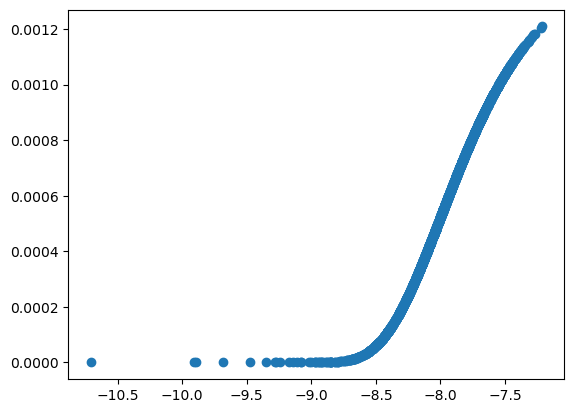

In [88]:
plt.scatter(np.log10(rr), c6['mbp'].mle_pi0 * np.exp(-1e-8/rr))


In [62]:
slope, intercept

(0.0003809049368015543, 0.00406754071660471)

pi0 exp(-U) - pi0 exp(R) = a + b log(R)

In [71]:
a, b = slope, intercept / c6['mbp'].mle_pi0

In [79]:
# here a = intercept / pi0 = exp(-U)
# and b = slope / pi0 = exp(R)
a, b

(0.0003809049368015543, 2.8561122037058575)

In [81]:
-np.log10(a) / 1e6, -np.log10(slope) / 1e6

(3.419183398534173e-06, 3.419183398534173e-06)

Let's look now at these high outliers.

In [ ]:
d.iloc[(resid > 0.001)]

In [ ]:
plt.plot(allbins.midpoints()['chr1'], c6['mbp'].resid()[allbins.chrom_indices('chr1')])

In [ ]:
plt.plot(allbins.midpoints()['chr6'], c6['mbp'].resid()[allbins.chrom_indices('chr6')])

Positive residuals = observation > prediction, e.g. excess of $\pi$ compared to prediction. This is MHC. 

In [ ]:
plt.plot(allbins.midpoints()['chr9'], c6['mbp'].resid()[allbins.chrom_indices('chr9')])

So most look centromere-related. 